In [1]:
import pandas as pd
import texthero as hero
from nltk.corpus import stopwords
import umap
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc
import seaborn as sns
from scipy import stats

data_dir = "data/"

In [4]:
import tqdm
tqdm.tqdm.pandas()

# Load Data

In [2]:
# don't load everything
chunks = pd.read_json(data_dir + "german_covid_full.jsonl", lines=True, chunksize=100_000)

In [3]:
# users = pd.json_normalize(tweets_df["user"])
# users.info()

In [5]:
impf_list = []
mask_list = []
trac_list = []

for chunk in tqdm.tqdm(chunks):
    impf_list.append(
        chunk[chunk["full_text"].str.lower().str.contains("impf")]
    )
    mask_list.append(
        chunk[chunk["full_text"].str.lower().str.contains("mask")]
    )
    trac_list.append(
        chunk[chunk["full_text"].str.lower().str.contains("trac")]
    )

34it [16:39, 29.40s/it]


In [6]:
impf = pd.concat(impf_list)  # impfstoff, impfung, impfen, ...
mask = pd.concat(mask_list)  # includes english stem as well
trac = pd.concat(trac_list)  # trace and track
len(impf), len(mask), len(trac)

(63676, 136198, 13151)

In [7]:
pd.to_datetime(impf["created_at"]).min(), pd.to_datetime(impf["created_at"]).max()

(Timestamp('2020-01-29 01:06:59'), Timestamp('2020-08-10 23:56:30'))

In [8]:
pd.to_datetime(mask["created_at"]).min(), pd.to_datetime(mask["created_at"]).max()

(Timestamp('2020-01-29 02:45:04'), Timestamp('2020-08-10 23:55:38'))

In [9]:
pd.to_datetime(trac["created_at"]).min(), pd.to_datetime(trac["created_at"]).max()

(Timestamp('2020-01-29 05:50:37'), Timestamp('2020-08-10 23:52:55'))

# Sentiment Analysis

In [10]:
from textblob_de import BlobberDE
blobber = BlobberDE()

In [11]:
def map_sentiment_textblob(text):
    tb = blobber(text)
    return tb.sentiment.polarity

In [13]:
impf["sent_tb"] = impf["full_text"].progress_map(map_sentiment_textblob)
impf["sent_tb"].describe()

100%|██████████| 63676/63676 [11:20<00:00, 93.55it/s] 


count    63676.000000
mean         0.078003
std          0.384029
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.175000
max          1.000000
Name: sent_tb, dtype: float64

In [15]:
impf["sent_tb"].to_csv("data/r63_user/twitter_full_vacc.csv", sep=";")

In [16]:
mask["sent_tb"] = mask["full_text"].progress_map(map_sentiment_textblob)
mask["sent_tb"].describe()

100%|██████████| 136198/136198 [24:10<00:00, 93.90it/s] 


count    136198.000000
mean          0.026916
std           0.349173
min          -1.000000
25%           0.000000
50%           0.000000
75%           0.116667
max           1.000000
Name: sent_tb, dtype: float64

In [17]:
mask["sent_tb"].to_csv("data/r63_user/twitter_full_mask.csv", sep=";")

In [18]:
trac["sent_tb"] = trac["full_text"].progress_map(map_sentiment_textblob)
trac["sent_tb"].describe()

100%|██████████| 13151/13151 [02:31<00:00, 86.97it/s] 


count    13151.000000
mean         0.067178
std          0.344481
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.170000
max          1.000000
Name: sent_tb, dtype: float64

In [19]:
trac["sent_tb"].to_csv("data/r63_user/twitter_full_ct.csv", sep=";")

### Only keep tweets that express a sentiment

Objective statements might not represent a sentiment. Including those would not help the analysis, as it would dominate the dataset.
We use the assumption that the space is continous and thus remove just clearly non-sentiment (e.g., purely objective) tweets would not necesarily lead to a bimodal distribution.
Another way of looking at it is that we could also remove any particular value (e.g., 0.5) without altering the overall distribution. 
Note that things would change if we remove an interval instead (e.g., [-0.5, 0.5] would alwayls lead to a bimodal distribution, since no peak can emerge in the middle).

In [15]:
# Verify the assumption
impf["sent_tb"].value_counts(), mask["sent_tb"].value_counts(), trac["sent_tb"].value_counts()

( 0.000000    32680
  1.000000     3841
  0.350000     1953
  0.700000     1816
  0.500000     1804
              ...  
 -0.013333        1
 -0.416667        1
 -0.230000        1
  0.254167        1
 -0.361111        1
 Name: sent_tb, Length: 545, dtype: int64,
  0.000000    65854
  0.500000     5679
  0.350000     4675
 -0.500000     4342
 -1.000000     3626
              ...  
 -0.264286        1
  0.733333        1
 -0.058333        1
 -0.043750        1
 -0.190000        1
 Name: sent_tb, Length: 886, dtype: int64,
  0.000000    6441
  0.350000     432
  0.500000     388
  0.700000     378
  1.000000     368
              ... 
  0.094444       1
  0.444444       1
 -0.108333       1
 -0.425000       1
 -0.200000       1
 Name: sent_tb, Length: 289, dtype: int64)

# Calculating Statistics

In [16]:
impf_w = impf[impf["sent_tb"] != 0]
mask_w = mask[mask["sent_tb"] != 0]
trac_w = trac[trac["sent_tb"] != 0]
len(impf_w), len(mask_w), len(trac_w)

(25769, 60218, 4819)

In [17]:
print("impf")
# print(stats.normaltest(impf_w['sent_tb'].values))
print(f"var:  {impf_w['sent_tb'].var()}")
print(f"skew: {impf_w['sent_tb'].skew()}")
print(f"kurt: {impf_w['sent_tb'].kurt()}")
impf_w["sent_tb"].describe()

impf
var:  0.32336269277512053
skew: -0.28684917131819093
kurt: -0.8114604917033961


count    25769.000000
mean         0.182344
std          0.568650
min         -1.000000
25%         -0.283333
50%          0.250000
75%          0.666667
max          1.000000
Name: sent_tb, dtype: float64

In [18]:
print("mask")
# print(stats.normaltest(mask_w['sent_tb'].values))
print(f"var:  {mask_w['sent_tb'].var()}")
print(f"skew: {mask_w['sent_tb'].skew()}")
print(f"kurt: {mask_w['sent_tb'].kurt()}")
mask_w["sent_tb"].describe()

mask
var:  0.25346369690772363
skew: -0.28866174158489377
kurt: -0.5556439693137918


count    60218.000000
mean         0.054637
std          0.503452
min         -1.000000
25%         -0.333333
50%          0.166667
75%          0.425000
max          1.000000
Name: sent_tb, dtype: float64

In [19]:
print("trac")
# print(stats.normaltest(trac_w['sent_tb'].values))
print(f"var:  {trac_w['sent_tb'].var()}")
print(f"skew: {trac_w['sent_tb'].skew()}")
print(f"kurt: {trac_w['sent_tb'].kurt()}")
trac_w["sent_tb"].describe()

trac
var:  0.2575038330195423
skew: -0.38547096269278414
kurt: -0.4020327348633086


count    4819.000000
mean        0.152787
std         0.507448
min        -1.000000
25%        -0.233333
50%         0.233333
75%         0.500000
max         1.000000
Name: sent_tb, dtype: float64

# Plotting

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette(sns.color_palette("blend:gray,white"))

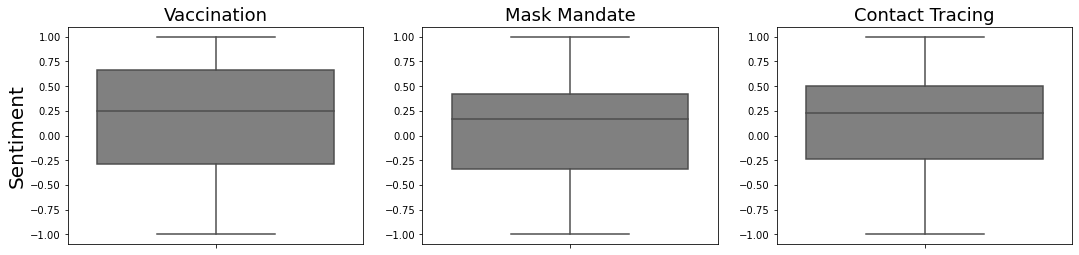

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,4))
sns.boxplot(data=impf_w, y="sent_tb", ax=ax[0])
sns.boxplot(data=mask_w, y="sent_tb", ax=ax[1])
sns.boxplot(data=trac_w, y="sent_tb", ax=ax[2])
ax[0].set_title("impf")
ax[1].set_title("mask")
ax[2].set_title("trac");

ax[0].set_ylabel("Sentiment", fontsize=20)
ax[1].set_ylabel("")
ax[2].set_ylabel("")

ax[0].set_title("Vaccination", fontsize=18)
ax[1].set_title("Mask Mandate", fontsize=18)
ax[2].set_title("Contact Tracing", fontsize=18);

In [29]:
len(impf_w) + len(mask_w) + len(trac_w)

90806